# **Clustering**

clustering

#### Loading datasets for K-Means and HAC:

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

small_dataset = np.load("data/small_dataset.npy")
small_labels = np.load("data/small_dataset_labels.npy").astype(int)
large_dataset = np.load("data/large_dataset.npy")

## K-Means

In [78]:
class KMeans(object):
    # K is the K in KMeans
    def __init__(self, K):
        self.K = K
        self.centroids = None
        self.labels = None
        self.objective_values = []

    # X is a (N x 28 x 28) array where 28x28 is the dimensions of each of the N images.
    def fit(self, X, max_iterations=10):
        # ed 300 said use std normal
        self.centroids = np.random.randn(self.K, X.shape[1])

        for _ in range(max_iterations):
            distances = distance.cdist(X, self.centroids, 'euclidean')
            self.labels = np.argmin(distances, axis=1)

            new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.K)])

            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids

            objective = np.sum([np.sum((X[self.labels == k] - self.centroids[k])**2) for k in range(self.K)])
            self.objective_values.append(objective)

    def get_mean_images(self):
        return self.centroids.reshape(self.K, 784)
    
    # TODO: change this for part 1's plot
    def plot_verify_objective(self):
        plt.plot(range(len(self.objective_values)), self.objective_values)
        plt.xlabel('Iteration')
        plt.ylabel('Objective Function')
        plt.title('K-means Objective Function')
        plt.show()

    
    # TODO: change this for part 5
    def get_cluster_sizes(self):
        return np.bincount(self.labels)

### Part 1: This takes seconds to run

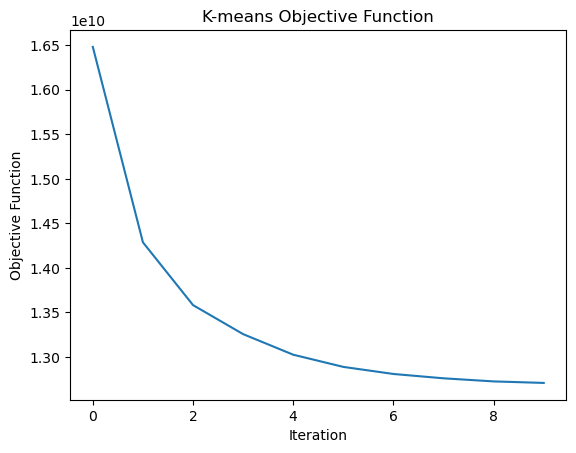

In [79]:
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
KMeansClassifier.plot_verify_objective()

Plotting code for parts 2 and 3

In [80]:
def make_mean_image_plot(data, standardized = False):
    niters = 3  
    K = 10
    allmeans = np.zeros((K, niters, 784))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K)
        KMeansClassifier.fit(data)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    plt.show()

### Part 2: This takes ~3 minutes to run

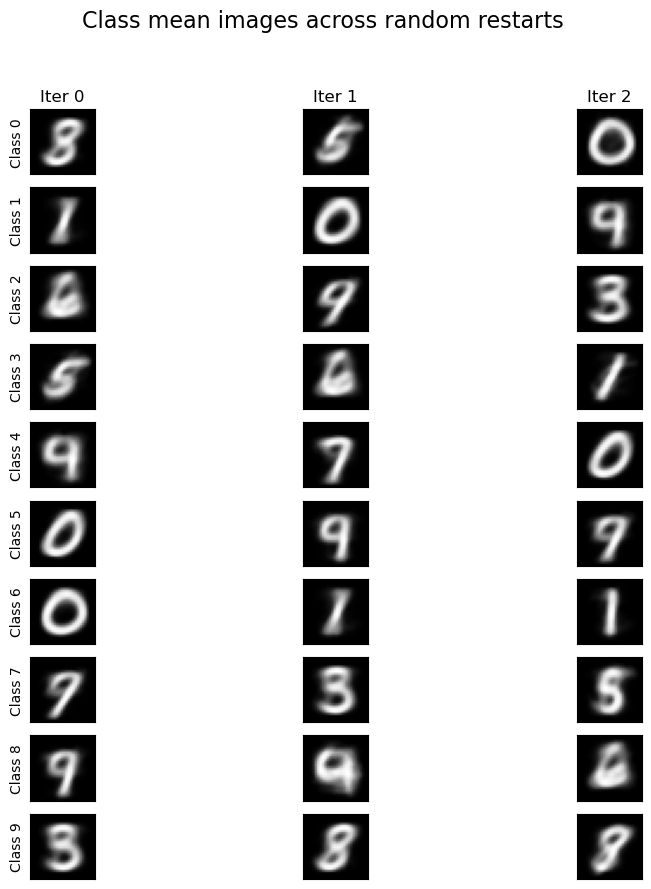

In [81]:
make_mean_image_plot(large_dataset)

### Part 3: This takes ~3 minutes to run

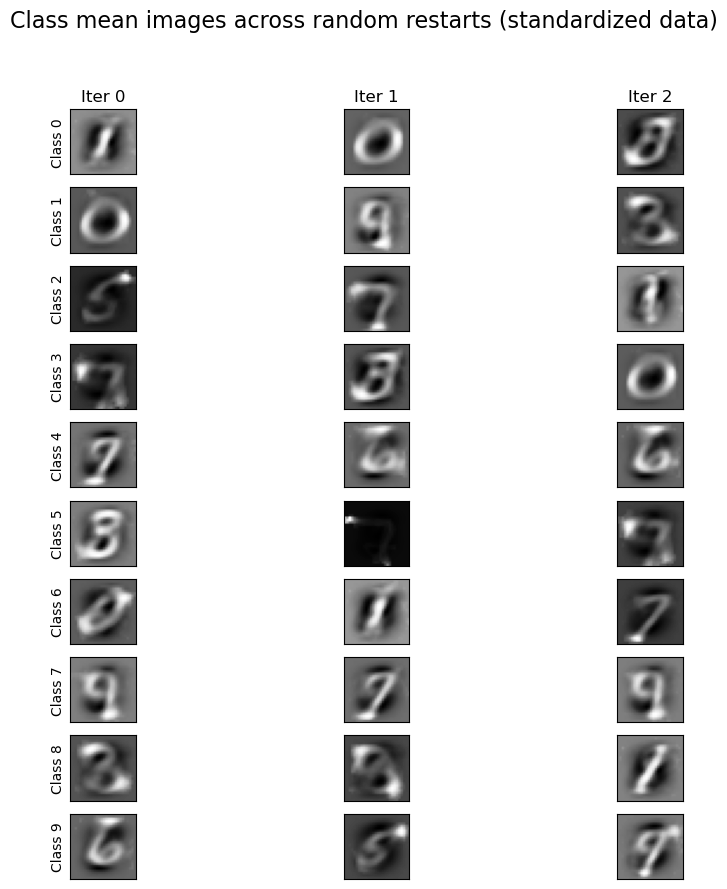

In [82]:
pixel_means = large_dataset.mean(axis=0)
pixel_stds = large_dataset.std(axis=0)
pixel_stds[pixel_stds == 0] = 1
large_dataset_std = (large_dataset - pixel_means) / pixel_stds
make_mean_image_plot(large_dataset_std, standardized = True)

## HAC: Part 4

In [57]:
class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
        self.labels = None
        self.centroids = None

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels = np.arange(n_samples)
        distances = cdist(X, X, 'euclidean')

        for _ in range(n_samples - 10):  #i am trying to do until 10?
            min_dist = np.inf
            merge_pair = None

            for i in range(n_samples):
                for j in range(i + 1, n_samples):
                    if self.labels[i] != self.labels[j]:
                        if self.linkage == 'min':
                            dist = distances[self.labels == self.labels[i]][:, self.labels == self.labels[j]].min()
                        elif self.linkage == 'max':
                            dist = distances[self.labels == self.labels[i]][:, self.labels == self.labels[j]].max()
                        elif self.linkage == 'centroid':
                            centroid_i = X[self.labels == self.labels[i]].mean(axis=0)
                            centroid_j = X[self.labels == self.labels[j]].mean(axis=0)
                            dist = np.linalg.norm(centroid_i - centroid_j)

                        if dist < min_dist:
                            min_dist = dist
                            merge_pair = (i, j)

            if merge_pair is not None:
                new_label = min(self.labels[merge_pair[0]], self.labels[merge_pair[1]])
                old_label = max(self.labels[merge_pair[0]], self.labels[merge_pair[1]])
                self.labels[self.labels == old_label] = new_label

        self.centroids = np.array([X[self.labels == k].mean(axis=0) for k in np.unique(self.labels)])
    def get_mean_images(self, n_clusters):
        return self.centroids[:n_clusters]

    def get_k_clusters(self, K):
        unique_labels = np.unique(self.labels)
        if len(unique_labels) < K:
            print("WTF")
        labels_k = np.zeros_like(self.labels)
        for i, label in enumerate(unique_labels):
            labels_k[self.labels == label] = i
        return labels_k

    def get_cluster_sizes(self, K):
        labels_k = self.get_k_clusters(K)
        if labels_k is not None:
            cluster_sizes = np.bincount(labels_k)
            if len(cluster_sizes) < K:
                cluster_sizes = np.pad(cluster_sizes, (0, K - len(cluster_sizes)), mode='constant')
            return cluster_sizes
        else:
            return None

### Part 4: This takes ~6 minutes to run


Linkage: max
Linkage: max
Number of unique labels: 10
Centroids shape: (10, 784)
Getting mean images for 10 clusters
Mean images shape: (10, 784)
Cluster sizes: [  5  29  13  47 145  39   4   7   7   4]
Plotting mean image for cluster 0
Plotting mean image for cluster 1
Plotting mean image for cluster 2
Plotting mean image for cluster 3
Plotting mean image for cluster 4
Plotting mean image for cluster 5
Plotting mean image for cluster 6
Plotting mean image for cluster 7
Plotting mean image for cluster 8
Plotting mean image for cluster 9
Done: max

Linkage: min
Linkage: min
Number of unique labels: 10
Centroids shape: (10, 784)
Getting mean images for 10 clusters
Mean images shape: (10, 784)
Cluster sizes: [285   2   1   1   6   1   1   1   1   1]
Plotting mean image for cluster 0
Plotting mean image for cluster 1
Plotting mean image for cluster 2
Plotting mean image for cluster 3
Plotting mean image for cluster 4
Plotting mean image for cluster 5
Plotting mean image for cluster 6
Plot

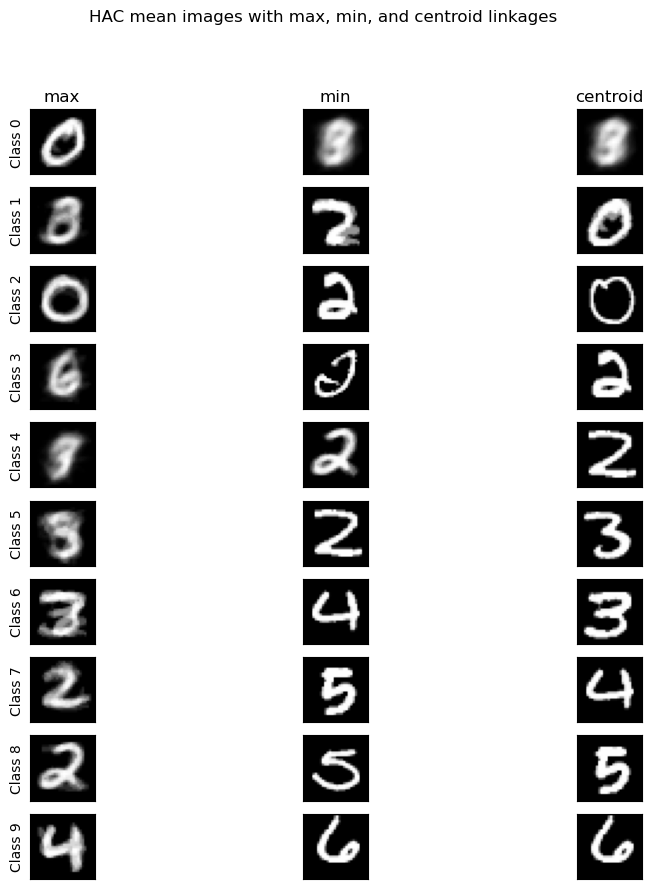

In [58]:
LINKAGES = ['max', 'min', 'centroid']
n_clusters = 10
cluster_sizes = []
fig = plt.figure(figsize=(10, 10))
plt.suptitle("HAC mean images with max, min, and centroid linkages")

for l_idx, l in enumerate(LINKAGES):
    print(f"\nLinkage: {l}")
    
    # Fit HAC
    hac = HAC(l)
    hac.fit(small_dataset)
    mean_images = hac.get_mean_images(n_clusters)
    print(f"Mean images shape: {mean_images.shape}")
    
    cluster_sizes.append(hac.get_cluster_sizes(n_clusters))
    print(f"Cluster sizes: {cluster_sizes[-1]}")
    
    # Make plot
    for m_idx in range(mean_images.shape[0]):
        print(f"Plotting mean image for cluster {m_idx}")
        
        m = mean_images[m_idx]
        ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        
        if m_idx == 0:
            plt.title(l)
        if l_idx == 0:
            ax.set_ylabel('Class '+str(m_idx), rotation=90)
        
        plt.imshow(m.reshape(28, 28), cmap='Greys_r')

    print("Done:", l)

plt.show()

### Part 5

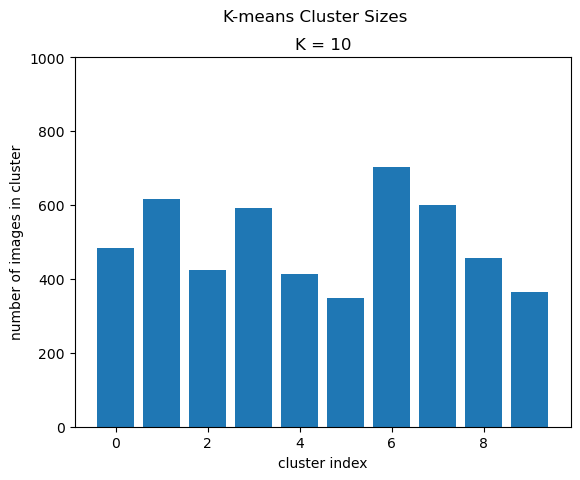

In [59]:
# Part 5: Create the graph for comparing cluster sizes in K-means
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle("K-means Cluster Sizes")
    ax.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, k):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'K = {k}')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 1000)

    plot_sizes_per_linkage(ax, cluster_sizes, str(n_clusters))
    plt.show()

plot_cluster_sizes(KMeansClassifier.K, KMeansClassifier.get_cluster_sizes())

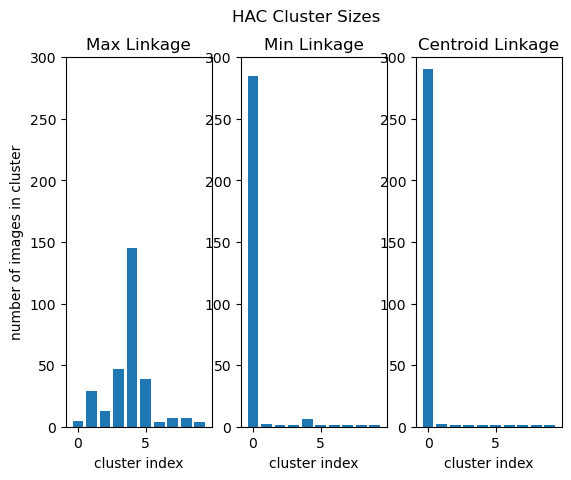

In [60]:
# Part 5: Create the graph for comparing cluster sizes in HAC
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("HAC Cluster Sizes")
    ax1.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, linkage):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'{linkage} Linkage')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 300)

    plot_sizes_per_linkage(ax1, cluster_sizes[0], 'Max')
    plot_sizes_per_linkage(ax2, cluster_sizes[1], 'Min')
    plot_sizes_per_linkage(ax3, cluster_sizes[2], 'Centroid')
    plt.show()
plot_cluster_sizes(n_clusters, cluster_sizes)

### Part 6: Confusion Matrix

/var/folders/vg/sd1whmqs18v5jcnh9r7pscz00000gn/T/ipykernel_1788/1557710817.py:18: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.K)])
/Users/purabseth/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Linkage: min
Number of unique labels: 10
Centroids shape: (10, 784)
Linkage: max
Number of unique labels: 10
Centroids shape: (10, 784)
Linkage: centroid
Number of unique labels: 10
Centroids shape: (10, 784)


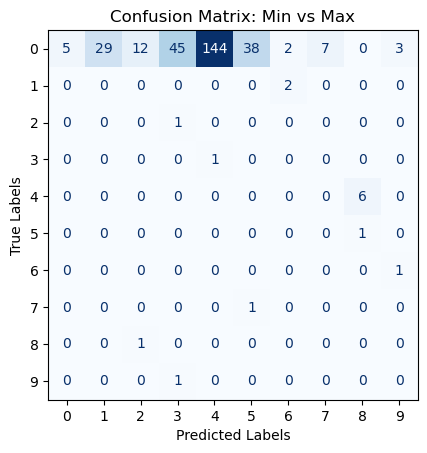

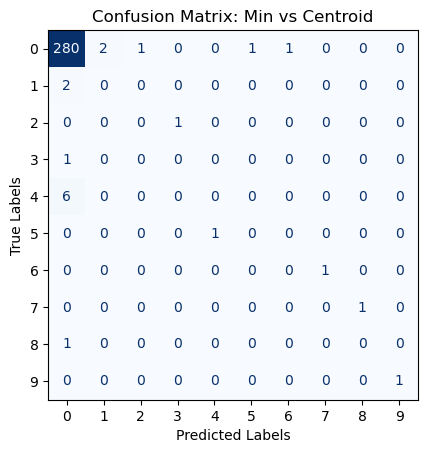

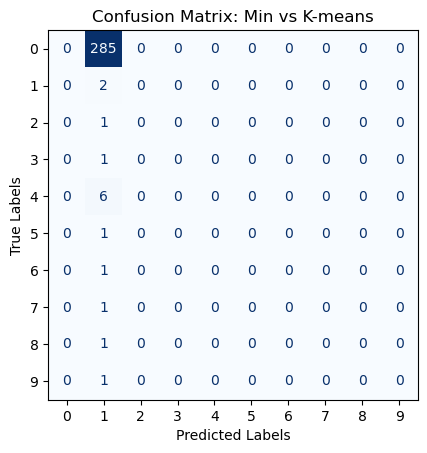

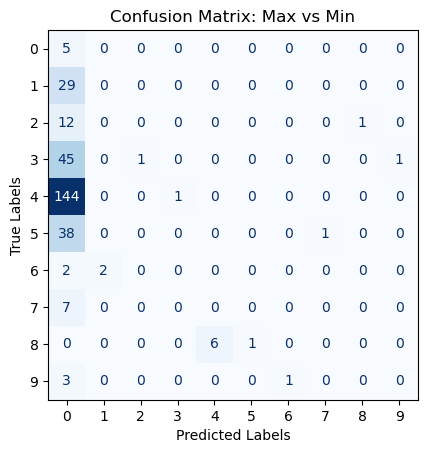

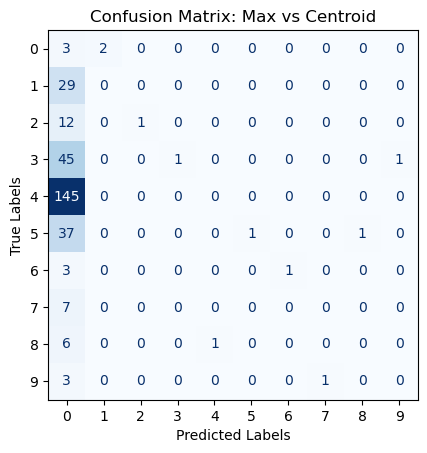

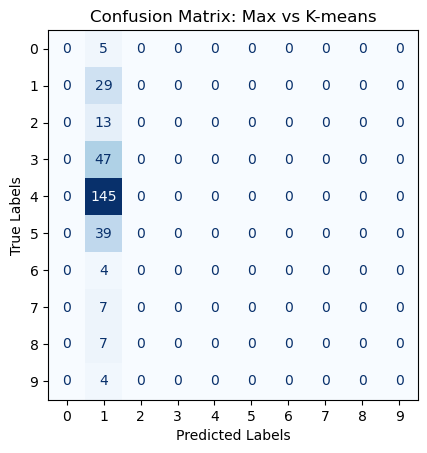

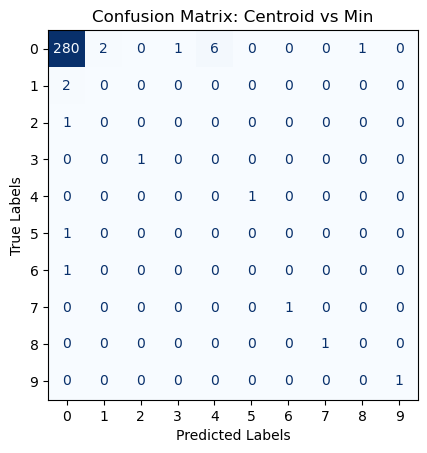

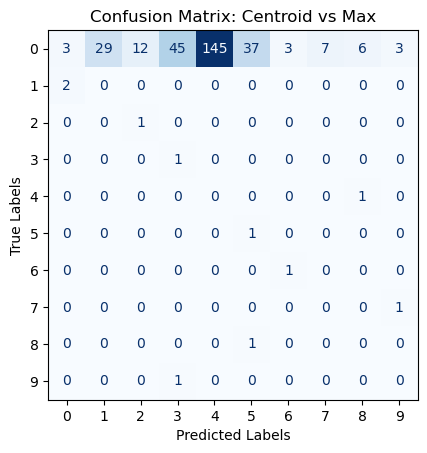

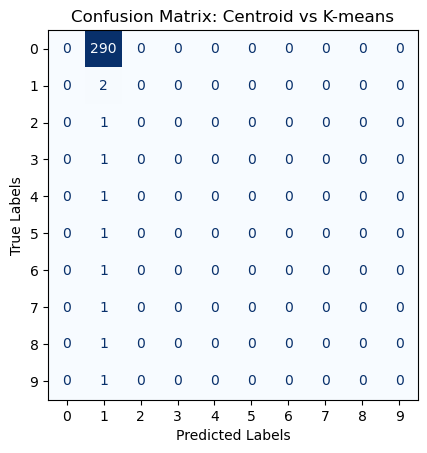

In [87]:
def plot_confusion_matrix(labels1, labels2, title):
    cm = confusion_matrix(labels1, labels2)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, square=True)
    plt.xlabel('Method 1 Clusters')
    plt.ylabel('Method 2 Clusters')
    plt.title(title)
    plt.show()

kmeans = KMeans(K=10)
kmeans.fit(small_dataset)
kmeans_labels = kmeans.labels

linkages = ['min', 'max', 'centroid']
hac_labels = {}
for linkage in linkages:
    hac = HAC(linkage)
    hac.fit(small_dataset)
    hac_labels[linkage] = hac.get_k_clusters(10)

for linkage1 in linkages:
    for linkage2 in linkages:
        if linkage1 != linkage2:
            title = f'Confusion Matrix: {linkage1.capitalize()} vs {linkage2.capitalize()}'
            plot_confusion_matrix(hac_labels[linkage1], hac_labels[linkage2], title)
    
    title = f'Confusion Matrix: {linkage1.capitalize()} vs K-means'
    plot_confusion_matrix(hac_labels[linkage1], kmeans_labels, title)